In [2]:
RKP = "DL031"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set_theme(style="darkgrid")

In [3]:
# Load datasets and rename columns, load all aqi data but specify metro data name
def loadcsv(city="./data/rkpuram.csv"):
    met = pd.read_csv(city,delimiter=';',skiprows=24)
    aqi = pd.read_csv('./data/station_hour.csv')
    print(aqi.columns)
    met.rename(columns={'# Date': 'Date',}, inplace=True)
    met.rename(columns={'UT time': 'Time',}, inplace=True)
    aqi['Time'] = aqi['Datetime'].str[-8:-3]
    aqi['Date'] = aqi['Datetime'].str[0:10]
    stations = ["DL"+str(x).zfill(3) for x in range(1,39)]
    split_aqi = {}
    for i in range(len(stations)):
        split_aqi[stations[i]] = (aqi[aqi['StationId'] == stations[i]])
    return met,aqi,split_aqi
met,aqi,split_aqi = loadcsv()

C:\Users\confusement\miniconda3\envs\mlc\lib\site-packages\IPython\core\interactiveshell.py:3263: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Index(['StationId', 'Datetime', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3',
       'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket'],
      dtype='object')


In [4]:
# Pre - processing and loading data
class dataset:
    def __init__(self,met,aqi,split_aqi):
            self.metro_data = met
            self.aqi_data = aqi
            self.split_aqi = split_aqi
    def mergedData(self,station,rlist=['PM2.5','PM10','NO','NO2','NOx','NH3','CO','SO2','O3'],roll=48,shift=168):
        df_aqi = self.getdf(station)
        df = pd.merge(df_aqi, self.metro_data, how='inner', on=['Date', 'Time'])
        print("Merged Dataset Size",len(df))
        
        #Pre Processing merged Data
        df['Year'] = df['Date'].str[0:4]
        df['Month'] = df['Date'].str[5:7].astype(np.float64)
        df['Day'] = df['Date'].str[8:10].astype(np.float64)
        df['Hour'] = df['Time'].str[0:2]
        
        # TRIG TRANSFORMATIONS
        df['windX'] = np.cos(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['windY'] = np.sin(np.deg2rad(df['Wind direction'])) * df['Wind speed']
        df['hourX'] = np.cos((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['hourY'] = np.sin((df['Hour'].astype(np.float64)-1)*np.pi/24)
        df['MonthX'] = np.cos((df['Month'].astype(np.float64)-1)*np.pi/12)
        df['MonthY'] = np.sin((df['Month'].astype(np.float64)-1)*np.pi/12)
        
        import datetime
        df['Date'] = pd.to_datetime(df['Date'])
        df['isWeekend'] =  (df['Date'].dt.dayofweek>=5).astype(int)
        
        df.interpolate(method='linear', limit=5,inplace=True)
        
        # Drop Additional columns
        df.drop('Benzene', axis=1, inplace=True)
        df.drop('Toluene',axis=1, inplace=True)
        df.drop('Xylene', axis=1,inplace=True)
        df.drop('AQI_Bucket',axis=1,inplace=True)
        df.drop('Datetime',axis=1,inplace=True)
        df.drop('StationId',axis=1,inplace=True)
        df.drop('Short-wave irradiation',axis=1,inplace=True)
        df.drop('Date',axis=1,inplace=True)
        df.drop('Time',axis=1,inplace=True)
        
        # Rolling and shifting 
        print("Size before roll",len(df))
        for i in rlist:
            df[i+'_lag1'] = df[i].shift(24)
            df[i+'_lag2'] = df[i].shift(48)
        for i in rlist:
            df[i+"_pred1"] = df[i].shift(-24)
            df[i+"_pred2"] = df[i].shift(-48)
        newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
        for i in newlist:
            for j in range(24):
                df[i+"_t-"+str(j)] = df[i].shift(j)
                df[i+"_t+"+str(j)] = df[i].shift(-j-shift)
        df.dropna(inplace=True)
        print("Size after roll",len(df))
        
        return df.copy()
    def getdf(self,station):
        return self.split_aqi[station]
    def plot(self,station):
        df = self.getdf(station)
    def stats(self):
        pass
dat = dataset(met,aqi,split_aqi)
df = dat.mergedData('DL031')
df

Merged Dataset Size 44035
Size before roll 44035
Size after roll 12790


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,AQI,...,isWeekend_t-19,isWeekend_t+19,isWeekend_t-20,isWeekend_t+20,isWeekend_t-21,isWeekend_t+21,isWeekend_t-22,isWeekend_t+22,isWeekend_t-23,isWeekend_t+23
165,33.00,102.17,6.33,14.45,22.22,23.65,0.17,10.27,18.08,429.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
166,95.17,184.83,6.72,15.63,23.86,22.06,20.00,11.97,18.58,429.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
167,77.50,164.67,8.15,32.28,41.18,26.91,8.00,17.28,20.33,318.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
168,65.50,154.33,7.64,90.45,94.00,30.74,17.00,18.81,29.83,318.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
170,60.50,310.17,14.19,116.38,121.56,28.73,15.00,15.16,33.33,318.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43839,18.00,53.00,2.80,20.73,13.30,22.40,0.83,15.35,13.27,79.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
43840,14.00,48.00,2.55,41.08,23.93,16.75,0.72,12.18,15.43,77.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
43841,16.00,46.00,2.85,18.00,11.90,25.40,0.62,12.35,17.43,72.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
43842,9.00,45.00,1.10,17.65,10.30,36.00,0.70,10.35,13.00,69.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [13]:
# CNN Model Testing as well
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
print(len(newlist))
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
predVector = []
for j in range(24):
    predVector.append('PM2.5_t+'+str(j))
X = df[features]
y = df[predVector]
X.shape
np.array(X).reshape(12790,15,24)
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)
print(Xtrain.shape)
with tf.device('/CPU:0'):
    model = Sequential()
    model.add(Dense(200, input_dim=360, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(24, activation='linear'))
    model.summary()
    #Fit
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(scaler.transform(Xtrain), ytrain, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)
    #Print Accuracy
    testPred = model.predict(scaler.transform(Xtest))
    trainPred = model.predict(scaler.transform(Xtrain))
    print(mean_squared_error(testPred, ytest,squared=False))
    print(mean_squared_error(trainPred, ytrain,squared=False))

15


array([[[33.0, 17.5, 34.5, ..., 29.0, 34.2, 52.5],
        [102.17, 43.33, 90.83, ..., 89.83, 111.67, 223.67],
        [6.33, 6.57, 6.04, ..., 8.3, 7.07, 6.53],
        ...,
        [-0.25881904510252063, -0.1305261922200516,
         6.123233995736766e-17, ..., -0.4999999999999998,
         -0.3826834323650895, -0.25881904510252063],
        [0.9659258262890683, 0.9914448613738104, 1.0, ...,
         0.8660254037844387, 0.9238795325112868, 0.9659258262890683],
        [1, 1.0, 1.0, ..., 0.0, 0.0, 0.0]],

       [[95.17, 33.0, 17.5, ..., 42.67, 29.0, 34.2],
        [184.83, 102.17, 43.33, ..., 111.5, 89.83, 111.67],
        [6.72, 6.33, 6.57, ..., 7.13, 8.3, 7.07],
        ...,
        [-0.3826834323650895, -0.25881904510252063, -0.1305261922200516,
         ..., -0.6087614290087207, -0.4999999999999998,
         -0.3826834323650895],
        [0.9238795325112868, 0.9659258262890683, 0.9914448613738104,
         ..., 0.7933533402912352, 0.8660254037844387,
         0.9238795325112868],


In [17]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))

X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = LinearRegression().fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.5695458844542312
54.50302447946837
55.00987602265274


In [16]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
        
X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = MLPRegressor(random_state=1, max_iter=100).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

C:\Users\confusement\miniconda3\envs\mlc\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


0.685427631493239
46.59265479233718
42.94414431488849


In [18]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression , mutual_info_regression
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
dfTrain = df[:]
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features.append("PM2.5_lag1")
features.append("PM2.5_lag2")

features.append("PM10_lag1")
features.append("PM10_lag2")

features.append("NO2_lag1")
features.append("NO2_lag2")

features.append("SO2_lag1")
features.append("SO2_lag2")

features.append("NO_lag1")
features.append("NO_lag2")

features.append("NOx_lag1")
features.append("NOx_lag2")

features.append("CO_lag1")
features.append("CO_lag2")

features.append("O3_lag1")
features.append("O3_lag2")

features.append("NH3_lag1")
features.append("NH3_lag2")

# features = []
# rlist=['PM2.5','PM10','NO','NO2','CO']
# newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
# for i in newlist:
#     for j in range(24):
#         features.append(i+'_t-'+str(j))

X = df[features]
y = df['PM2.5_pred1']
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)

reg = SVR(C=1.0, epsilon=0.2).fit(scaler.transform(Xtrain), ytrain)

testPred = reg.predict(scaler.transform(Xtest))
trainPred = reg.predict(scaler.transform(Xtrain))
mse = np.mean((testPred - np.array(ytest))*(testPred - np.array(ytest)))
print(reg.score(scaler.transform(Xtest), ytest))
print(mean_squared_error(testPred, ytest,squared=False))
print(mean_squared_error(trainPred, ytrain,squared=False))

0.44686265572761963
61.78366409828595
63.108555288839455


In [7]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [48]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
features = ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
features = []
rlist=['PM2.5','PM10','NO','NO2','CO']
newlist = rlist + ['Temperature','Relative Humidity','windX','windY','Year','MonthX','MonthY','hourX','hourY','isWeekend']
for i in newlist:
    for j in range(24):
        features.append(i+'_t-'+str(j))
predVector = []
for j in range(24):
    predVector.append('PM2.5_t+'+str(j))
X = df[features]
y = df[predVector]
scaler = StandardScaler()
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.33, random_state=42)
scaler.fit(Xtrain)
print(Xtrain.shape)
with tf.device('/CPU:0'):
    model = Sequential()
    model.add(Dense(200, input_dim=360, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(24, activation='linear'))
    model.summary()
    #Fit
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    history = model.fit(scaler.transform(Xtrain), ytrain, epochs=100, batch_size=50,  verbose=1, validation_split=0.2)
    #Print Accuracy
    testPred = model.predict(scaler.transform(Xtest))
    trainPred = model.predict(scaler.transform(Xtrain))
    print(mean_squared_error(testPred, ytest,squared=False))
    print(mean_squared_error(trainPred, ytrain,squared=False))

(8569, 360)
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 200)               72200     
_________________________________________________________________
dense_87 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_88 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_89 (Dense)             (None, 24)                2424      
Total params: 104,824
Trainable params: 104,824
Non-trainable params: 0
_________________________________________________________________
Train on 6855 samples, validate on 1714 samples
Epoch 1/100
6855/6855 [==============================] - 1s 115us/step - loss: 8309.0508 - mse: 8309.0508 - mae: 63.0670 - val_loss: 4379.9809 - val_mse: 4379.9805 - val_mae: 46.6007
Ep

Epoch 85/100
6855/6855 [==============================] - 1s 113us/step - loss: 919.4138 - mse: 919.4137 - mae: 21.2870 - val_loss: 1454.2937 - val_mse: 1454.2937 - val_mae: 26.6006
Epoch 86/100
6855/6855 [==============================] - 1s 115us/step - loss: 910.4268 - mse: 910.4268 - mae: 21.1605 - val_loss: 1456.6155 - val_mse: 1456.6154 - val_mae: 26.6129
Epoch 87/100
6855/6855 [==============================] - 1s 112us/step - loss: 896.8170 - mse: 896.8169 - mae: 20.9925 - val_loss: 1434.1384 - val_mse: 1434.1384 - val_mae: 26.4222
Epoch 88/100
6855/6855 [==============================] - 1s 107us/step - loss: 889.4265 - mse: 889.4266 - mae: 20.9226 - val_loss: 1429.7807 - val_mse: 1429.7809 - val_mae: 26.2525
Epoch 89/100
6855/6855 [==============================] - 1s 92us/step - loss: 884.4129 - mse: 884.4128 - mae: 20.8641 - val_loss: 1448.8451 - val_mse: 1448.8450 - val_mae: 26.5517
Epoch 90/100
6855/6855 [==============================] - 1s 98us/step - loss: 880.1832 - m

dict_keys(['val_loss', 'val_mse', 'val_mae', 'loss', 'mse', 'mae'])


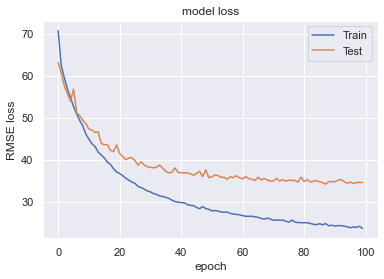

In [38]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(np.sqrt(history.history['loss']))
plt.plot(np.sqrt(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('RMSE loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()